In [1]:
import yaw_estimation.models as models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import shutil
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
importlib.reload(models)
cuda = torch.device('cuda')


## Parameters

In [2]:
DATASET = "fast_tunnel_traversal"
DATASET_FOLDER = f"/home/lorenzo/datasets/{DATASET}"
MODEL = models.YawEstimator
SAVE_FOLDER = f"/home/lorenzo/models/gallery_detection/procedural_datasets/{DATASET}"
n_epochs = int(64*2)
batch_size = 128
lr = 0.002
try:
    os.mkdir(SAVE_FOLDER)
except:
    pass
save_path = os.path.join(SAVE_FOLDER,MODEL.__name__+f"-_bs{batch_size}_ne{n_epochs}_lr{str(lr).replace('.','_')}.torch")
print(save_path)

/home/lorenzo/models/gallery_detection/procedural_datasets/fast_tunnel_traversal/YawEstimator-_bs128_ne128_lr0_002.torch


## Load dataset

In [3]:
# Define the dataset
class ImageDataset(Dataset):
    def __init__(self, path_to_dataset, max_elements_per_env=None):
        self.device = torch.device(
            "cuda:0")
        self.load_dataset(path_to_dataset,max_elements_per_env=max_elements_per_env)
        self.data_augmentation=torch.nn.Sequential(
            transforms.RandomErasing()
        )
    def load_dataset(self, dataset_folder, max_elements_per_env = None):
        n_datapoints = 0
        envs = os.listdir(dataset_folder)
        envs.sort()
        for env in envs:
            env_folder = os.path.join(dataset_folder, env)
            data_folder = os.path.join(env_folder, "data")
            if os.path.isdir(data_folder):
                if max_elements_per_env is None:
                    n_datapoints += len(os.listdir(data_folder))
                else:
                    n_datapoints+=min(len(os.listdir(data_folder)),max_elements_per_env)
            else:
                envs.remove(env)
        self.n_datapoints = n_datapoints
        self.labels = torch.zeros((self.n_datapoints, 1)).float()
        self.images = torch.zeros((self.n_datapoints,1,30,30)).float()
        n = 0
        for env in envs:
            print(env)
            env_folder = os.path.join(dataset_folder, env)
            data_folder = os.path.join(env_folder, "data")
            dtp_names = os.listdir(data_folder)
            dtp_names.sort()
            if not max_elements_per_env is None:
                dtp_names = dtp_names[0:min(len(dtp_names),max_elements_per_env)]
            for dtp_n, dtp_name in enumerate(dtp_names):
                print(f"{dtp_n:04d}",end="\r")
                dtp_path = os.path.join(data_folder, dtp_name)
                dtp = np.load(dtp_path)
                self.labels[n, :] = torch.tensor(dtp["label"])
                self.images[n,0, :,:] = torch.tensor(dtp["image"])
                n+=1

    def __len__(self):
        return self.n_datapoints

    def __getitem__(self, idx):
        image = self.images[idx, ...]
        result = self.labels[idx, ...]
        return image.float(), result.float()
    def delete(self, idx):
        self.images = torch.cat(self.images[0:idx,...],self.images[idx+1,:])
        self.labels= torch.cat(self.labels[0:idx,...],self.labels[idx+1,:])

dataset = ImageDataset(DATASET_FOLDER,max_elements_per_env=None)

env_001
env_002
env_003
env_004
env_005
env_006
env_007
env_008
env_009
env_010
env_011
env_012
env_013
env_014
env_015
env_016
env_017
env_018
env_019
env_020


In [4]:
n = 0

tensor([28.6240])


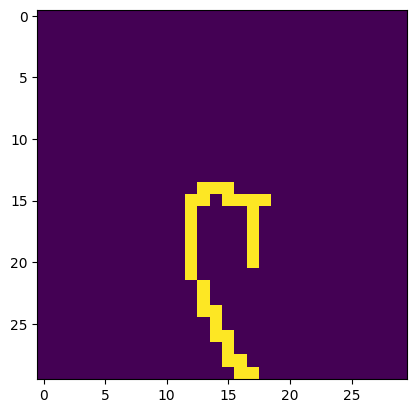

In [5]:
image, result = dataset[n]
n+=1
print(np.rad2deg(result))
plt.imshow(image[0])
plt.show()

In [6]:
train_dataset, test_dataset = random_split(dataset,[0.9,0.1])
torch.cuda.empty_cache()
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=5)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=5)
    

### Explore dataset

In [7]:
def basic_train(network, train_loader, criterion, optimizer, n_epochs,lr,tensorborad_folder="/home/lorenzo/tensor_board"):
    shutil.rmtree(tensorborad_folder) 
    os.mkdir(tensorborad_folder)
    writer = SummaryWriter(log_dir=tensorborad_folder)
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print("", end="\r")
        print("Epoch {} out of {}".format(
            epoch + 1, n_epochs), end="")
        for i, data in enumerate(train_loader):
            torch.cuda.empty_cache()
            inputs, labels = data
            inputs = inputs.to(torch.device("cuda"))
            labels = labels.to(torch.device("cuda"))
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            j = i + epoch * train_loader.__len__()
            writer.add_scalar(f"Loss/train/lr_{lr}",loss,j)

### Train

In [8]:
if False:
    with open("/home/lorenzo/models/gallery_detection/procedural_datasets/dataset_03/gallery_detector_v3-_r10_lr002_3.torch", "rb") as f:
        network.load_state_dict(torch.load(f))

In [9]:
lrs = [0.1*0.65**n for n in range(20)]
for i in lrs:
    print(f"{i:05f}")

0.100000
0.065000
0.042250
0.027463
0.017851
0.011603
0.007542
0.004902
0.003186
0.002071
0.001346
0.000875
0.000569
0.000370
0.000240
0.000156
0.000102
0.000066
0.000043
0.000028


In [10]:
criterion = nn.MSELoss()

for lr in lrs:
    network = MODEL().to(cuda).float()
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(
        network.parameters(),
        lr=lr,
    )
    loss_hist = basic_train(
        network, train_dataloader, criterion, optimizer, n_epochs, lr
    )
    lr_str = f"{lr:04f}".replace(".", "_")
    save_path = os.path.join(SAVE_FOLDER,MODEL.__name__+f"-_bs{batch_size}_ne{n_epochs}_lr{lr_str}.torch")
    print(save_path)
    network.to("cpu")
    torch.save(network.state_dict(), save_path)

Epoch 128 out of 128/home/lorenzo/models/gallery_detection/procedural_datasets/fast_tunnel_traversal/YawEstimator-_bs128_ne128_lr0_100000.torch
Epoch 128 out of 128/home/lorenzo/models/gallery_detection/procedural_datasets/fast_tunnel_traversal/YawEstimator-_bs128_ne128_lr0_065000.torch
Epoch 128 out of 128/home/lorenzo/models/gallery_detection/procedural_datasets/fast_tunnel_traversal/YawEstimator-_bs128_ne128_lr0_042250.torch
Epoch 128 out of 128/home/lorenzo/models/gallery_detection/procedural_datasets/fast_tunnel_traversal/YawEstimator-_bs128_ne128_lr0_027463.torch
Epoch 128 out of 128/home/lorenzo/models/gallery_detection/procedural_datasets/fast_tunnel_traversal/YawEstimator-_bs128_ne128_lr0_017851.torch
Epoch 128 out of 128/home/lorenzo/models/gallery_detection/procedural_datasets/fast_tunnel_traversal/YawEstimator-_bs128_ne128_lr0_011603.torch
Epoch 128 out of 128/home/lorenzo/models/gallery_detection/procedural_datasets/fast_tunnel_traversal/YawEstimator-_bs128_ne128_lr0_00754

In [11]:
save_path = "/home/lorenzo/models/gallery_detection/procedural_datasets/dataset_03/gallery_detector_v3-_r10_lr002_5.torch"
print(save_path)

/home/lorenzo/models/gallery_detection/procedural_datasets/dataset_03/gallery_detector_v3-_r10_lr002_5.torch
